## Some simple data explorations - Part 2

In [47]:
import pandas as pd
import numpy as np

user = pd.read_csv('./preprocessed1_train.csv')
hist = pd.read_csv('./ml_case_data/ml_case_training_hist_data.csv')
#churn = pd.read_csv('./ml_case_data/ml_case_training_output.csv')

### I have filtered out some columns with a lot null values, here are the ones remained

In [31]:
user.columns

Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'cons_last_month.1', 'date_activ', 'date_end', 'date_modif_prod',
       'date_renewal', 'forecast_cons_12m', 'forecast_cons_year',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_p1', 'forecast_price_energy_p2',
       'forecast_price_pow_p1', 'has_gas', 'imp_cons', 'margin_gross_pow_ele',
       'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig',
       'origin_up', 'pow_max'],
      dtype='object')

### In this part of data exploration, we need to process categorical values and date values in some columns into numerical values

#### Column 'channel_sales' has only 7 unique values! Perfect for one-hot encoding

In [48]:
channel = list(user.channel_sales.unique())
print (channel)
channels = []

for i in range(len(user)):
    temp = [0] * len(channel)
    temp[channel.index(user.iloc[i]['channel_sales'])] = 1
    channels.append(temp)
    
chan_cols = ['channel'+str(i) for i in range(len(channel))]
cha_df = pd.DataFrame(channels, columns=chan_cols)

['foosdfpfkusacimwkcsosbicdxkicaua', 'usilxuppasemubllopkaafesmlibmsdf', 'nodata', 'lmkebamcaaclubfxadlmueccxoimlema', 'ewpakwlliwisiwduibdlfmalxowmwpci', 'epumfxlbckeskwekxbiuasklxalciiuu', 'fixdbufsefwooaasfcxdxadsiekoceaa']


#### 'date_\*' columns are a little tricky. What I do here is get the earliest date in 'date_activ', and converts all other date values like 'date - min(date_activ)'. Very straightforward

In [49]:
from datetime import datetime

#start_date = user.date_activ.min()
start_date = '2000-07-25'
print (start_date)
FMT = '%Y-%m-%d'

days = []

for i in range(len(user)):
    days.append([(datetime.strptime(user.iloc[i]['date_activ'], FMT) - datetime.strptime(start_date, FMT)).days, \
                 (datetime.strptime(user.iloc[i]['date_end'], FMT) - datetime.strptime(start_date, FMT)).days, \
                 (datetime.strptime(user.iloc[i]['date_modif_prod'], FMT) - datetime.strptime(start_date, FMT)).days, \
                 (datetime.strptime(user.iloc[i]['date_renewal'], FMT) - datetime.strptime(start_date, FMT)).days])
    
days_cols = ['days_activ', 'days_end', 'days_modif', 'days_renewal']
days_df = pd.DataFrame(days, columns=days_cols)

2000-07-25


#### As for train_hist data, I will take mean value for each id, each column

In [50]:
prices = {}
ids = list(user.id.unique())

def price_mean(id):
    prices[id] = [hist[hist.id == id]['price_p1_var'].mean(), \
                   hist[hist.id == id]['price_p2_var'].mean(), \
                   hist[hist.id == id]['price_p3_var'].mean(), \
                   hist[hist.id == id]['price_p1_fix'].mean(), \
                   hist[hist.id == id]['price_p2_fix'].mean(), \
                   hist[hist.id == id]['price_p3_fix'].mean()]

list(map(price_mean, ids))

prices_lst = []
for i in list(user.id):
    prices_lst.append(prices[i])
prices_cols = ['prices_p1_var', 'prices_p2_var', 'prices_p3_var', 'prices_p1_fix', 'prices_p2_fix', 'prices_p3_fix']
prices_df = pd.DataFrame(prices_lst, columns=prices_cols)

#### Of course our churn label

In [37]:
churns = []
for i in range(len(user)):
    churns.append(int(churn[churn.id == user.iloc[i]['id']]['churn']))
churn_df = pd.DataFrame(churns, columns=['churn'])

#### And the 'has_gas' column? 0 and 1 will fix it

In [51]:
user_test = pd.read_csv('./preprocessed1_test.csv')
origin_up_ = list(user_test.origin_up.unique())
print (origin_up_)

['ldkssxwpmemidmecebumciepifcamkci', 'kamkkxfxxuwbdslkwifmmcsiusiuosws', 'lxidpiddsbxsbosboudacockeimpuepw', 'usapbepcfoloekilkwsdiboslwaxobdp', 'ewxeelcelemmiwuafmddpobolfuxioce']


In [53]:
has_gas = [1 if x == 't' else 0 for x in list(user.has_gas)]
user.has_gas = has_gas

origin_up = list(set(list(user.origin_up.unique()) + origin_up_ ))
print (origin_up)
origins = []

for i in range(len(user)):
    temp = [0] * len(origin_up)
    temp[origin_up.index(user.iloc[i]['origin_up'])] = 1
    origins.append(temp)
    
origins_cols = ['origin'+str(i) for i in range(len(origin_up))]
origin_df = pd.DataFrame(origins, columns=origins_cols)

['ewxeelcelemmiwuafmddpobolfuxioce', 'kamkkxfxxuwbdslkwifmmcsiusiuosws', 'ldkssxwpmemidmecebumciepifcamkci', 'aabpopmuoobccoxasfsksebxoxffdcxs', 'usapbepcfoloekilkwsdiboslwaxobdp', 'lxidpiddsbxsbosboudacockeimpuepw']


In [54]:
revised = user.drop(['channel_sales', 'date_activ', 'date_end', 'date_modif_prod', 'date_renewal', 'origin_up'], axis=1)

In [55]:
len(revised.columns)

20

### Save the processed data into 'all.csv'

In [56]:
all_df = pd.concat([revised, cha_df, days_df, origin_df, prices_df], axis=1)
all_df.to_csv('./all_train.csv', index=False)

### This is pretty much all about data cleansing/engineering. Before we start modeling, I would like to see the correlations between columns

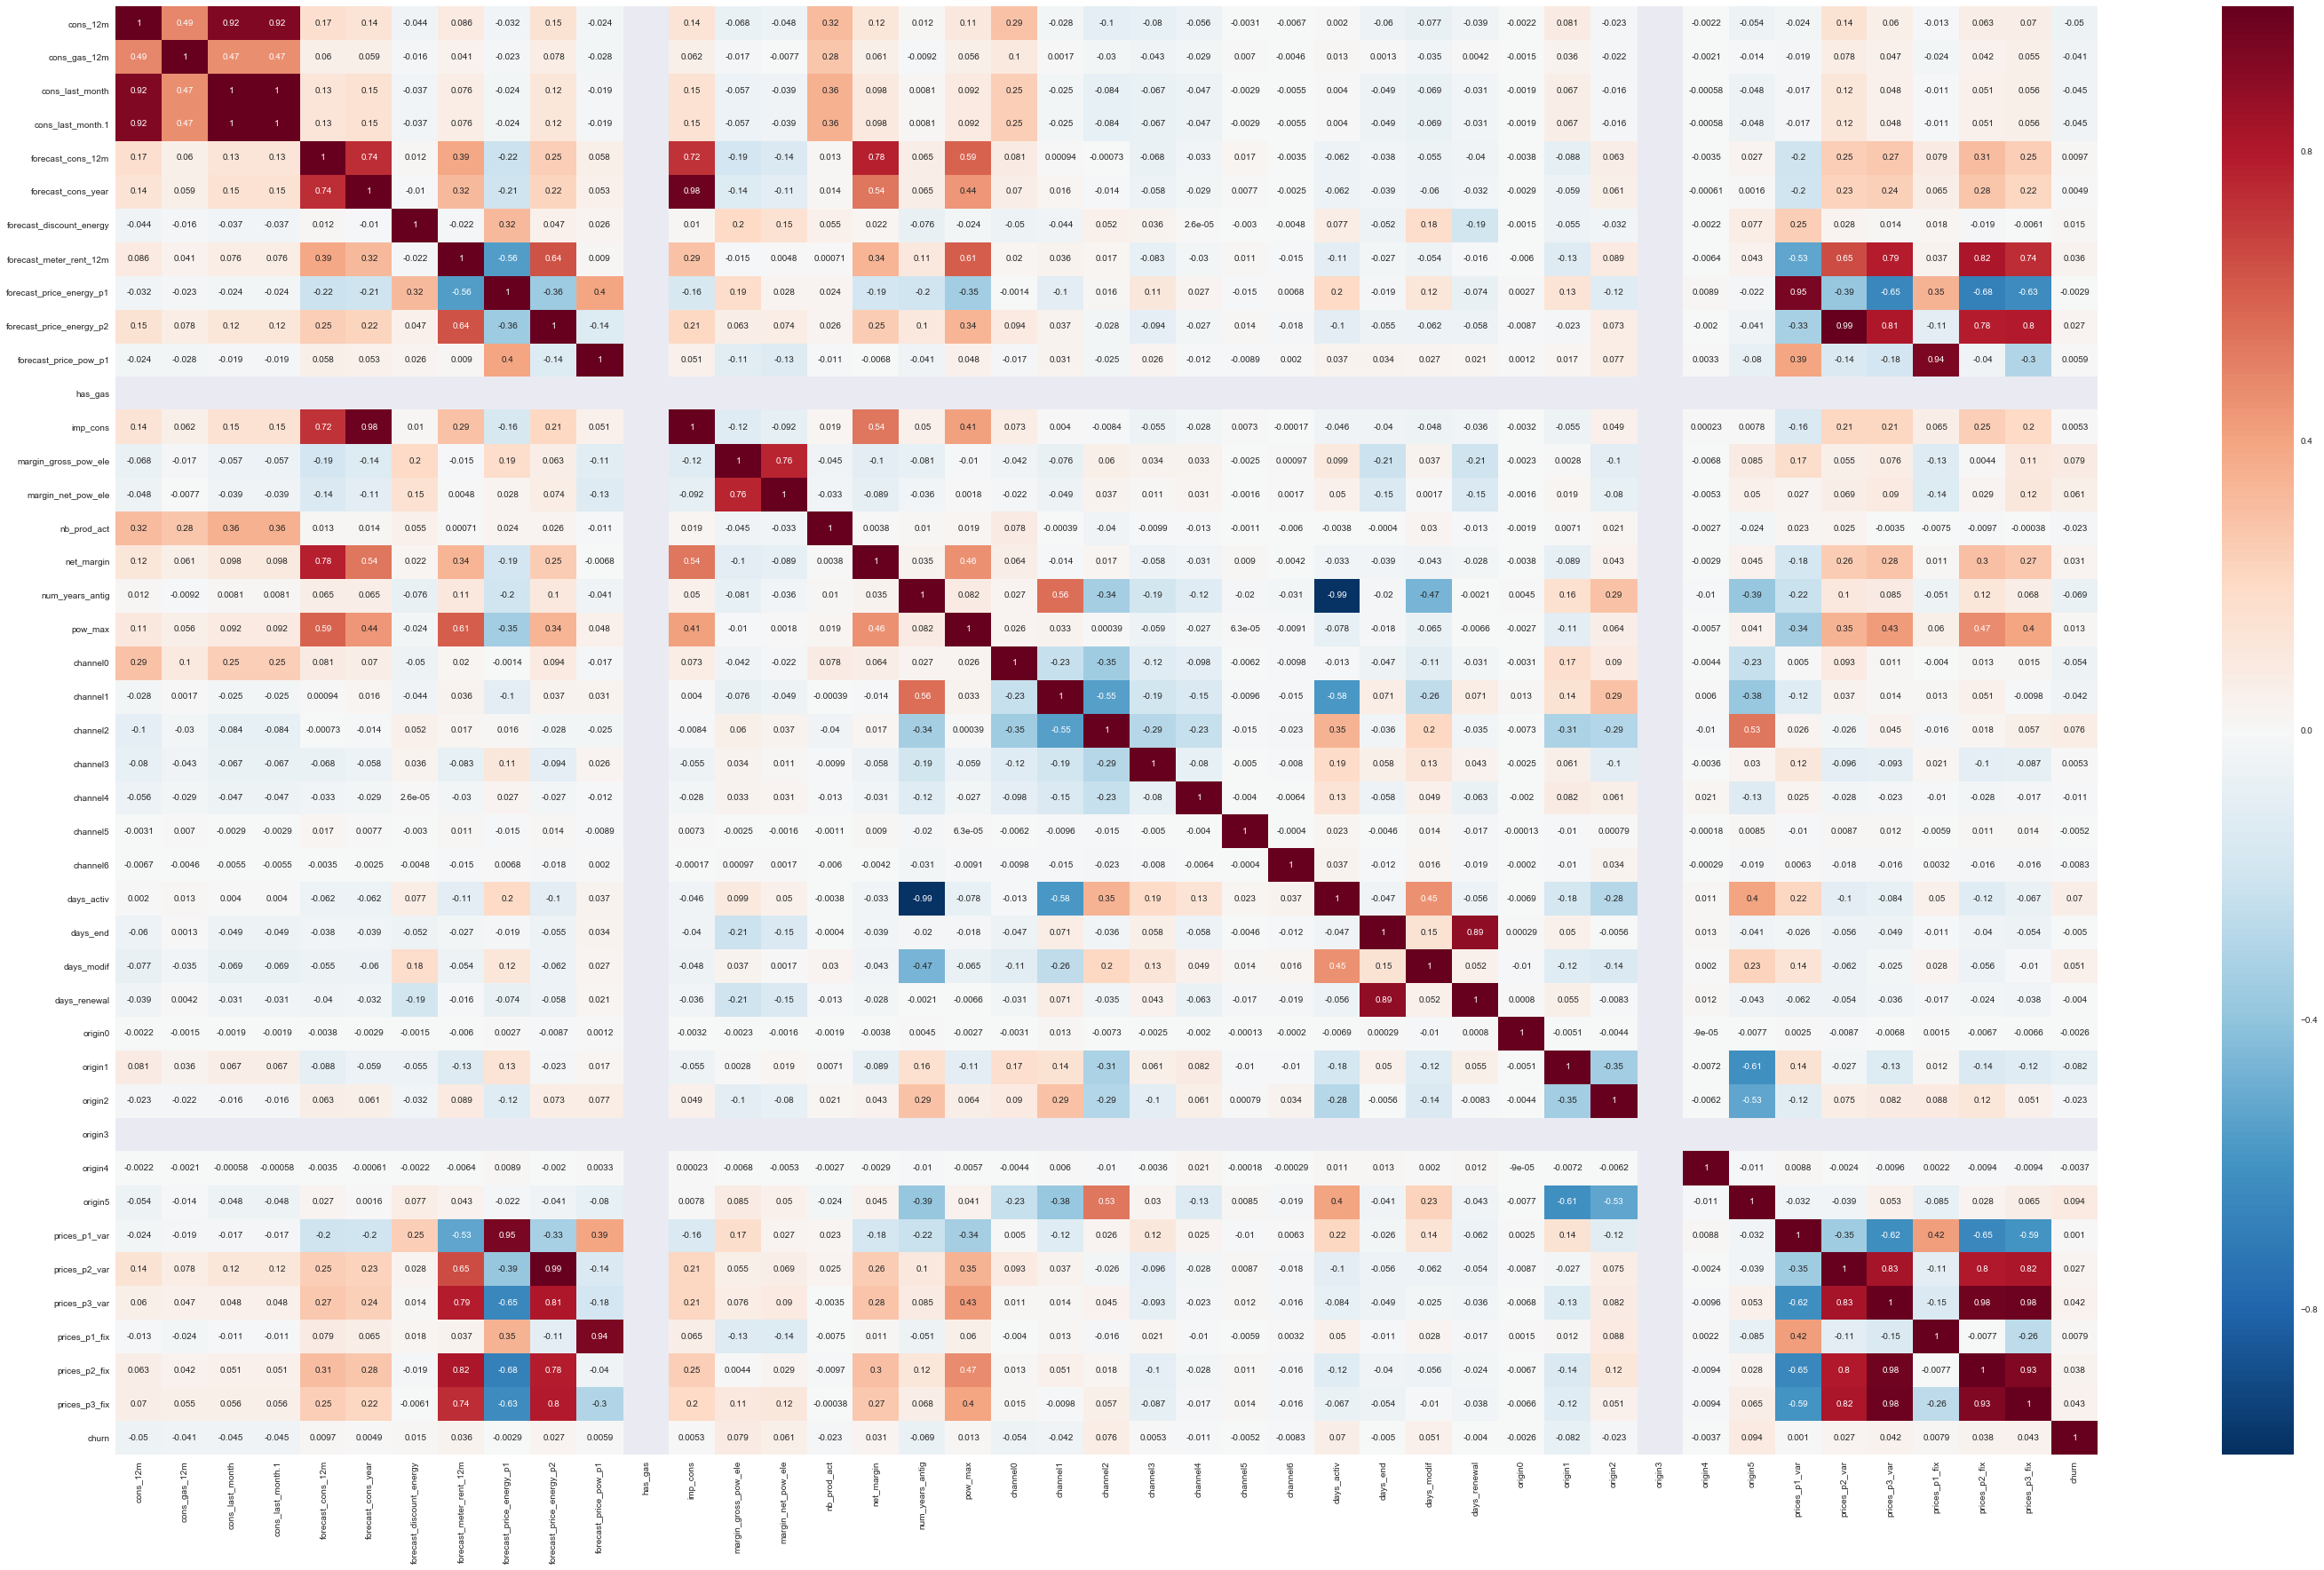

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('./all_train.csv').drop(['id'], axis=1)
corr = df.corr()
plt.figure(figsize = (50, 30))
sns.heatmap(corr, annot=True)
plt.show()